In [1]:
%cd /scratch/bruingjde/SNAM2021-code/

from constants import *

/scratch/bruingjde/SNAM2021-code


# Node temporal and static features

In [2]:
def get_featureset_III_performance(network_index: int, hypergraph: bool):
  # Start with static features
  X = {
    heuristic: np.load(
      f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy')
    for heuristic in heuristics
  }
    
  # Add temporal node features
  aggregation_strategies = [
    'm0', 'm1', 'm2', 'm3', 'q0', 'q25', 'q50', 'q75', 'q100'] # Overwrite!
  
  for time_strategy in time_strategies: # Provided in constants.py
    for nodepair_strategy in nodepair_strategies: # Provided in constants.py
      if hypergraph:
        for aggregation_strategy in aggregation_strategies:
          X[(time_strategy, nodepair_strategy, aggregation_strategy)] = np.load(
            f'data/{network_index:02}/features/time_node/'
            f'{time_strategy}_{nodepair_strategy}_{aggregation_strategy}.npy'
          )
      else:
        X[(time_strategy, nodepair_strategy)] = np.load(
          f'data/{network_index:02}/features/time_node/'
          f'{time_strategy}_{nodepair_strategy}.npy')
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

feature_III_performance = {
  network_index: (
    get_featureset_III_performance(
      network_index, hypergraph=network_index in hypergraph_indices
    )
  )
  for network_index in network_indices
}

# Edge temporal features

In [3]:
def get_featureset_II_performance(network_index: int, hypergraph: bool):
  aggregation_strategies = [
    'm0', 'm1', 'q0', 'q25', 'q50', 'q75', 'q100'] # Overwrite of constants.py!
  
  X = dict()
  
  for heuristic in heuristics: # Provided in constants.py
    for time_strategy in time_strategies: # Provided in constants.py
      if hypergraph:
        for aggregation_strategy in aggregation_strategies:
            X[(heuristic, time_strategy, aggregation_strategy)] = np.load(
              f'data/{network_index:02}/features/time_edge/'
              f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy')
      else:
        X[(heuristic, time_strategy)] = np.load(
          f'data/{network_index:02}/features/time_edge/'
          f'{heuristic}_{time_strategy}.npy')
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

feature_II_performance = {
  network_index: get_featureset_II_performance(
    network_index, hypergraph=network_index in hypergraph_indices
  )
  for network_index in network_indices
}

# Merge

In [11]:
x = 'Edge-centered features (AUC)'
y = 'Node-centered features (AUC)'
t = 'Scientific domain'

data = pd.DataFrame(
  {
    t: networks['category'].str.title(),
    y: pd.Series(feature_III_performance),
    x: pd.Series(feature_II_performance),
  }
)
# df.to_pickle('code/figures/temp.pkl')

# Figure

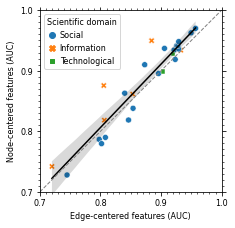

In [12]:
fontsize=8
rc = {
  'xtick.top': True, 'ytick.right': True, 'figure.figsize': (3.3,3.3), 
  'axes.titlesize': fontsize, 
  'axes.labelsize': fontsize, 
  'xtick.labelsize': fontsize, 
  'ytick.labelsize': fontsize, 
  'legend.fontsize': fontsize, 
  'legend.title_fontsize': fontsize,
  'lines.linewidth': 1,
#   'lines.markersize': 4,
  'legend.handlelength': .4,
  'font.family': 'sans-serif',
  'font.sans-serif': 'Helvetica',
  'savefig.transparent': True
}

with plt.rc_context(rc):
  ax = sns.scatterplot(data=data, x=x, y=y, hue=t, style=t)
  sns.regplot(data=data, x=x, y=y, scatter=False, color='black', ax=ax)
  ax.axline((0,0), (1,1), ls='--', c='grey')
  ax.axis('scaled')
  ax.axis([.7, 1, .7, 1])
  ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.1))
  ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.1))
  ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  plt.tight_layout()
  plt.savefig('code/figures/output/Fig7.pdf')